Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
!pip install git+https://github.com/huggingface/datasets#egg=datasets

  Cloning https://github.com/huggingface/datasets to /tmp/pip-install-c1ur2ha8/datasets_5028cd2b25794f1082660f92677724f9
  Running command git clone --filter=blob:none -q https://github.com/huggingface/datasets /tmp/pip-install-c1ur2ha8/datasets_5028cd2b25794f1082660f92677724f9
  Resolved https://github.com/huggingface/datasets to commit d7a3a76c12798b90de9e7fa41fd7007cd4d6ca27
  Preparing metadata (setup.py) ... done
  Created wheel for datasets: filename=datasets-2.0.1.dev0-py3-none-any.whl size=326571 sha256=63aa5a5b41feea73dd9de7d2e3a0f49375e77e033e763617dd9219cd4a7e4a8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8p00_m_0/wheels/cb/6a/f6/1b735389402c6a7cfd6af75fae91ac8ac34d900c197df34b67
Successfully built datasets
  Attempting uninstall: datasets
    Found existing installation: datasets 1.18.4
    Uninstalling datasets-1.18.4:
      Successfully uninstalled datasets-1.18.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

In [2]:
! pip install datasets 
! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [3]:
from datasets import load_dataset

In [4]:
import datasets

In [5]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
N = 10000
frac = 0.2
dataset['train'] = dataset['train'].shuffle(seed=42).select(indices=range(0,N))
dataset['test'] = dataset['test'].shuffle(seed=42).select(indices=range(0,int(N*frac)))

# Fine-tuning the model** (20 points)

In [7]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, InputFeatures,pipeline,
                          ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [8]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"
BATCH_SIZE = 512
EPOCHS = 30
LEARNING_RATE = 10e-4
NUM_WORKERS = 2
PATIENCE = 5 # amount of epochs without loss change to stop training
FREEZE = True

In [9]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 10)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [10]:
pipe = pipeline(model=MODEL_NAME)
pipe("Why don't you ask [MASK]?")

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

[{'score': 0.5343002080917358,
  'token': 2033,
  'token_str': 'me',
  'sequence': "why don't you ask me?"},
 {'score': 0.0819597840309143,
  'token': 3980,
  'token_str': 'questions',
  'sequence': "why don't you ask questions?"},
 {'score': 0.043953415006399155,
  'token': 2068,
  'token_str': 'them',
  'sequence': "why don't you ask them?"},
 {'score': 0.04017249867320061,
  'token': 2339,
  'token_str': 'why',
  'sequence': "why don't you ask why?"},
 {'score': 0.030024176463484764,
  'token': 4426,
  'token_str': 'yourself',
  'sequence': "why don't you ask yourself?"}]

In [11]:
pipe("What is [MASK]?")

[{'score': 0.4963121712207794,
  'token': 2009,
  'token_str': 'it',
  'sequence': 'what is it?'},
 {'score': 0.2050580382347107,
  'token': 2023,
  'token_str': 'this',
  'sequence': 'what is this?'},
 {'score': 0.12763574719429016,
  'token': 2008,
  'token_str': 'that',
  'sequence': 'what is that?'},
 {'score': 0.015324683859944344,
  'token': 3308,
  'token_str': 'wrong',
  'sequence': 'what is wrong?'},
 {'score': 0.015023304149508476,
  'token': 2054,
  'token_str': 'what',
  'sequence': 'what is what?'}]

In [12]:
pipe("Let's talk about [MASK] physics")

[{'score': 0.24027419090270996,
  'token': 8559,
  'token_str': 'quantum',
  'sequence': "let's talk about quantum physics"},
 {'score': 0.2125832438468933,
  'token': 9373,
  'token_str': 'theoretical',
  'sequence': "let's talk about theoretical physics"},
 {'score': 0.05639351159334183,
  'token': 10811,
  'token_str': 'particle',
  'sequence': "let's talk about particle physics"},
 {'score': 0.03320807218551636,
  'token': 2613,
  'token_str': 'real',
  'sequence': "let's talk about real physics"},
 {'score': 0.022627977654337883,
  'token': 8045,
  'token_str': 'mathematical',
  'sequence': "let's talk about mathematical physics"}]

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

columns = list(dataset['train'].features.keys())
columns.remove('topic')
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=columns)
tokenized_datasets = tokenized_datasets.rename_column("topic", "labels")
tokenized_datasets.set_format("torch")

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
from torch.utils.data import DataLoader
trainloader = DataLoader(tokenized_datasets['train'],shuffle=True,  
                         batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
testloader = DataLoader(tokenized_datasets['test'], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [15]:
if FREEZE:
    for param in model.electra.parameters():
          param.requires_grad = False

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print('')

In [18]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import f1_score

def compute_F1(true,pred):
    pred = pred.argmax(dim=(-1))
    return f1_score(true.cpu(), pred.cpu(), average='weighted')

# Set seed for reproducibility
np.random.seed(2021)
torch.manual_seed(2021)

progress_bar = tqdm(range(len(trainloader)*EPOCHS))


metrics = {}
for m in ['train_loss','val_loss','train_f1','val_f1']:
    metrics[m] = []

for epoch in range(EPOCHS):
    running_loss = []
    running_f1 = []
    for batch in trainloader:
        model.train()

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss.append(float(loss))
        running_f1.append(compute_F1(batch['labels'],outputs.logits))

        progress_bar.update(1)
        progress_bar.set_description(
            f"Epoch: {epoch+1}/{EPOCHS}, loss: {np.mean(running_loss):.4f}, f1 score: {np.mean(running_f1):.4f}"
            )
    
    metrics['train_loss'].append(np.mean(running_loss))
    metrics['train_f1'].append(np.mean(running_f1))

    running_loss = []
    running_f1 = []
    for batch in testloader:
        model.eval()
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
        running_loss.append(float(loss))
        running_f1.append(compute_F1(batch['labels'],outputs.logits))
    metrics['val_loss'].append(np.mean(running_loss))
    metrics['val_f1'].append(np.mean(running_f1))
    print(f'Validation loss: {np.mean(running_loss):.4f}, f1 score: {np.mean(running_f1):.4f}')

    if epoch >= PATIENCE and np.std(metrics['val_loss'][-PATIENCE:]) < 1e-3:
      print('Early stopping condition is true')
      break
    torch.cuda.empty_cache()

print('Training finished') 

  0%|          | 0/600 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

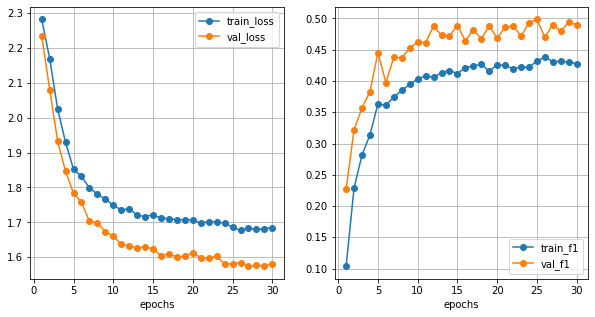

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for key in metrics.keys():
    if 'f1' in key:
        plt.subplot(122)
        plt.plot(np.arange(EPOCHS)+1, metrics[key], 'o-',label=key)
    else:
        plt.subplot(121)
        plt.plot(np.arange(EPOCHS)+1, metrics[key], 'o-',label=key)
    plt.grid(True)
    plt.xlabel('epochs')
    plt.legend()


In [20]:
model.save_pretrained("model")
model2 = ElectraForMaskedLM.from_pretrained("model")
pipe = pipeline("fill-mask", model=model2,tokenizer=tokenizer)
pipe("Why don't you ask [MASK]?")


Some weights of the model checkpoint at model were not used when initializing ElectraForMaskedLM: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at model and are newly initialized: ['generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.

[{'score': 0.000390280649298802,
  'token': 17029,
  'token_str': 'p a r a l y m p i c',
  'sequence': "why don't you ask paralympic?"},
 {'score': 0.00033108098432421684,
  'token': 20887,
  'token_str': 'u m p i r e',
  'sequence': "why don't you ask umpire?"},
 {'score': 0.00031521200435236096,
  'token': 11175,
  'token_str': 's u t t o n',
  'sequence': "why don't you ask sutton?"},
 {'score': 0.00031011170358397067,
  'token': 27206,
  'token_str': 'f o r b i d',
  'sequence': "why don't you ask forbid?"},
 {'score': 0.00029877893393859267,
  'token': 13522,
  'token_str': 'k o l k a t a',
  'sequence': "why don't you ask kolkata?"}]

In [21]:
pipe("What is [MASK]?")


[{'score': 0.00041817454621195793,
  'token': 13547,
  'token_str': 'o w l',
  'sequence': 'what is owl?'},
 {'score': 0.00032938283402472734,
  'token': 6680,
  'token_str': 'a s l e e p',
  'sequence': 'what is asleep?'},
 {'score': 0.0003092053811997175,
  'token': 18234,
  'token_str': 'i m p a i r e d',
  'sequence': 'what is impaired?'},
 {'score': 0.00030591472750529647,
  'token': 13204,
  'token_str': 'w h e e l c h a i r',
  'sequence': 'what is wheelchair?'},
 {'score': 0.00028471663244999945,
  'token': 22388,
  'token_str': 'o w l s',
  'sequence': 'what is owls?'}]

In [22]:
pipe("Let's talk about [MASK] physics")

[{'score': 0.00027219142066314816,
  'token': 26593,
  'token_str': 'l e t t e r m a n',
  'sequence': "let's talk about letterman physics"},
 {'score': 0.00027064024470746517,
  'token': 11267,
  'token_str': 'b e n g a l i',
  'sequence': "let's talk about bengali physics"},
 {'score': 0.000250261218752712,
  'token': 0,
  'token_str': '[ P A D ]',
  'sequence': "let's talk about physics"},
 {'score': 0.0002445296267978847,
  'token': 14920,
  'token_str': 'd e n i a l',
  'sequence': "let's talk about denial physics"},
 {'score': 0.00024003868747968227,
  'token': 23070,
  'token_str': '# # s k a y a',
  'sequence': "let's talk aboutskaya physics"}]